In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import slsim
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
from slsim.lens_pop import LensPop
from tqdm import tqdm

from mejiro.helpers import survey_sim

In [2]:
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/roman-like.yml")

configure_roman_filters()

roman_filters = filter_names()

_ = speclite.filters.load_filters(
    roman_filters[0],
    roman_filters[1],
    roman_filters[2],
    roman_filters[3],
    roman_filters[4],
    roman_filters[5],
    roman_filters[6],
    roman_filters[7],
)

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

sky_area = Quantity(value=5., unit="deg2")

Place stricter magnitude cuts on the second `LensPop`

In [4]:
kwargs_deflector_cut_1 = {"band": "F062", "band_max": 25, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut_1 = {"band": "F062", "band_max": 28, "z_min": 0.01, "z_max": 5.0}

lens_pop_1 = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut_1,
    kwargs_source_cut=kwargs_source_cut_1,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [5]:
kwargs_deflector_cut_2 = {"band": "F062", "band_max": 22, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut_2 = {"band": "F062", "band_max": 23, "z_min": 0.01, "z_max": 5.0}

lens_pop_2 = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut_2,
    kwargs_source_cut=kwargs_source_cut_2,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [6]:
kwargs_lens_cut = {
    "min_image_separation": 0.2,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 25, "F106": 25, "F062": 25},
}

lens_population_1 = lens_pop_1.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

print("Number of lenses:", len(lens_population_1))

Number of lenses: 56596


In [7]:
lens_population_2 = lens_pop_2.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

print("Number of lenses:", len(lens_population_2))

Number of lenses: 416


So far, this makes sense: there are fewer systems in the second population with stricter filters on magnitudes.

In [8]:
detectable_gglenses_1, snr_1 = [], []
for candidate in tqdm(lens_population_1):
    # 1. Einstein radius and Sersic radius
    _, kwargs_params = candidate.lenstronomy_kwargs(band='F106')
    lens_mag = candidate.deflector_magnitude(band='F106')

    if kwargs_params['kwargs_lens'][0]['theta_E'] < kwargs_params['kwargs_lens_light'][0][
        'R_sersic'] and lens_mag < 15:
        continue

    # 2. SNR
    snr, _ = survey_sim.get_snr(candidate, 'F106')
    snr_1.append(snr)

    if snr < 10:
        continue

    # if both criteria satisfied, consider detectable
    detectable_gglenses_1.append(candidate)

  0%|          | 6/56596 [00:00<17:37, 53.51it/s]

100%|██████████| 56596/56596 [18:34<00:00, 50.76it/s]


In [9]:
detectable_gglenses_2, snr_2 = [], []
for candidate in tqdm(lens_population_2):
    # 1. Einstein radius and Sersic radius
    _, kwargs_params = candidate.lenstronomy_kwargs(band='F106')
    lens_mag = candidate.deflector_magnitude(band='F106')

    if kwargs_params['kwargs_lens'][0]['theta_E'] < kwargs_params['kwargs_lens_light'][0][
        'R_sersic'] and lens_mag < 15:
        continue

    # 2. SNR
    snr, _ = survey_sim.get_snr(candidate, 'F106')
    snr_2.append(snr)

    if snr < 10:
        continue

    # if both criteria satisfied, consider detectable
    detectable_gglenses_2.append(candidate)

100%|██████████| 416/416 [00:08<00:00, 51.53it/s]


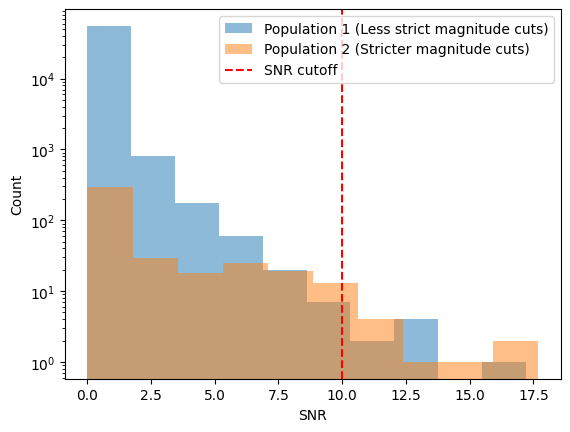

In [10]:
plt.hist(snr_1, label='Population 1 (Less strict magnitude cuts)', alpha=0.5)
plt.hist(snr_2, label='Population 2 (Stricter magnitude cuts)', alpha=0.5)
plt.xlabel('SNR')
plt.ylabel('Count')
plt.yscale('log')
plt.axvline(10, color='r', linestyle='--', label='SNR cutoff')
plt.legend()
plt.show()

In [11]:
print(f'Number of detectable lenses in the population 1: {len(detectable_gglenses_1)}')
print(f'Percentage detectable in population 1: {len(detectable_gglenses_1) / len(lens_population_1) * 100:.2f}%')

Number of detectable lenses in the population 1: 9
Percentage detectable in population 1: 0.02%


In [12]:
print(f'Number of detectable lenses in population 2: {len(detectable_gglenses_2)}')
print(f'Percentage detectable in population 2: {len(detectable_gglenses_2) / len(lens_population_2) * 100:.2f}%')

Number of detectable lenses in population 2: 11
Percentage detectable in population 2: 2.64%
